# Two-Component Self-Activation Loop with Hill Function UDE

This notebook demonstrates how to:

1. **Generate synthetic data** from a known two-component self-activation loop model containing a Hill function.
2. **Construct a universal differential equation (UDE)** that treats the Hill function as unknown and learns it with a neural network.
3. **Train the neural network** to discover the unknown nonlinear activation dynamics.
4. **Visualize** the trained model's performance and compare the learned function to the true Hill function.

We'll use:
- **NumPy** and **Matplotlib** for data manipulation and plotting.
- **`scipy.integrate.solve_ivp`** to generate synthetic data.
- **PyTorch** for neural network training.
- **`torchdiffeq`** for differentiable ODE solvers in PyTorch.

## Key Concept

In biological systems, **Hill functions** are widely used to model cooperative binding and activation/repression. In this notebook, we'll work with a two-component system where component $X$ is activated by component $Y$ through a Hill function:

$$\frac{dX}{dt} = v \cdot \frac{Y^n}{K^n + Y^n} - d \cdot X$$

$$\frac{dY}{dt} = X - d \cdot Y$$

Here:
- $v$ is the maximum production rate
- $K$ is the activation threshold (Hill constant)
- $n$ is the Hill coefficient (cooperativity)
- $d$ is the degradation rate

We'll treat the **Hill function** $\frac{Y^n}{K^n + Y^n}$ as **unknown** and let a neural network learn it from data!


In [119]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint

# For inline plotting
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)


## 2. Generate Synthetic "True" Data

We'll simulate the two-component self-activation loop model:

$$\frac{dX}{dt} = v \cdot \frac{Y^n}{K^n + Y^n} - d \cdot X$$

$$\frac{dY}{dt} = X - d \cdot Y$$

The **Hill function** in the first equation will be treated as "unknown" for our UDE. The linear production of $Y$ from $X$ and the degradation terms are assumed to be known.


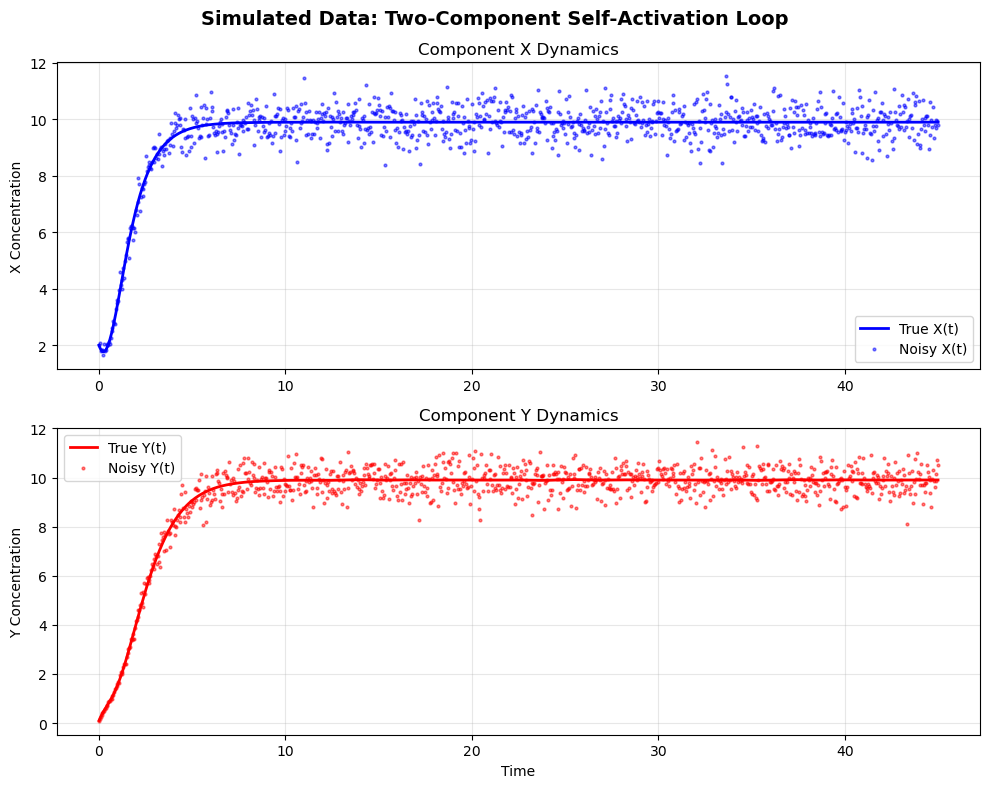

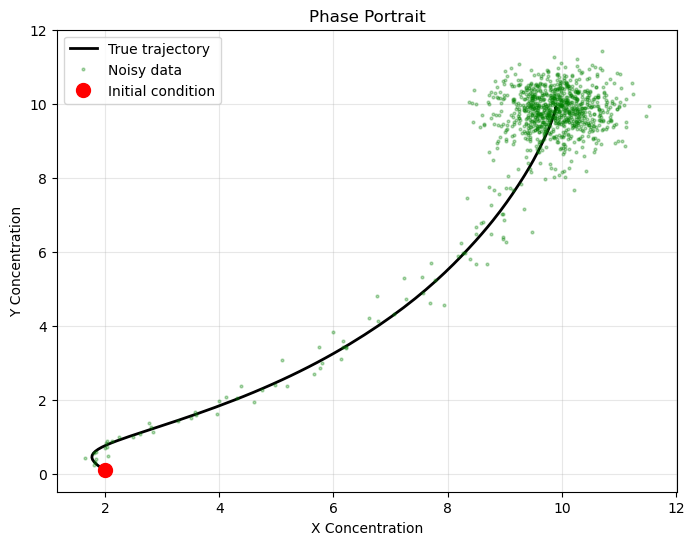

In [162]:
# Physical parameters (some known, some "unknown" in UDE context)
v_true = 10     # Maximum production rate (unknown - to be learned)
K_true = 1     # Hill constant (unknown - to be learned)
n_true = 2.0      # Hill coefficient (unknown - to be learned)
d = 1    # Degradation rate (assumed known)

def hill_activation_model(t, y):
    """
    Two-component self-activation loop with Hill function:
        y = [X, Y]
        dy/dt = [dX/dt, dY/dt]
    """
    X, Y = y
    
    # Hill function: Y^n / (K^n + Y^n)
    hill_term = (Y**n_true) / (K_true**n_true + Y**n_true)
    
    dX_dt = v_true * hill_term - d * X
    dY_dt = X - d * Y
    
    return [dX_dt, dY_dt]

# Initial conditions: X(0), Y(0)
X0 = 2.0
Y0 = 0.1
y0 = [X0, Y0]

# Time span for simulation
t_start, t_end = 0.0, 45.0
t_eval = np.linspace(t_start, t_end, 1000)

# Solve the ODE
sol = solve_ivp(hill_activation_model, [t_start, t_end], y0, t_eval=t_eval, method='RK45')
X_true = sol.y[0, :]
Y_true = sol.y[1, :]

# Add noise to simulate experimental data
noise_level = 0.05  # Relative noise level (5%)
X_noisy = X_true + noise_level * np.abs(X_true) * np.random.randn(len(X_true))
Y_noisy = Y_true + noise_level * np.abs(Y_true) * np.random.randn(len(Y_true))

# Plot the noisy data vs. true solution
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# X(t) plot
axes[0].plot(t_eval, X_true, 'b-', label='True X(t)', linewidth=2)
axes[0].plot(t_eval, X_noisy, 'b.', label='Noisy X(t)', alpha=0.5, markersize=4)
axes[0].set_ylabel('X Concentration')
axes[0].set_title('Component X Dynamics')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Y(t) plot
axes[1].plot(t_eval, Y_true, 'r-', label='True Y(t)', linewidth=2)
axes[1].plot(t_eval, Y_noisy, 'r.', label='Noisy Y(t)', alpha=0.5, markersize=4)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Y Concentration')
axes[1].set_title('Component Y Dynamics')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Simulated Data: Two-Component Self-Activation Loop', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Also show phase portrait
plt.figure(figsize=(8, 6))
plt.plot(X_true, Y_true, 'k-', label='True trajectory', linewidth=2)
plt.plot(X_noisy, Y_noisy, 'g.', label='Noisy data', alpha=0.3, markersize=4)
plt.plot(X0, Y0, 'ro', markersize=10, label='Initial condition')
plt.xlabel('X Concentration')
plt.ylabel('Y Concentration')
plt.title('Phase Portrait')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 3. Visualize the True Hill Function

Before we try to learn it, let's visualize what the true Hill function looks like as a function of $Y$.


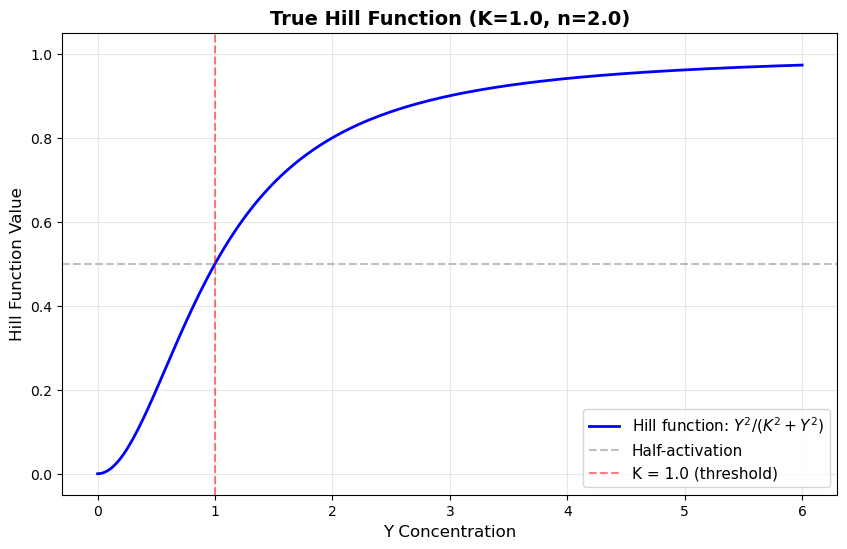

True parameters:
  v (max production) = 10.00
  K (Hill constant) = 1.00
  n (Hill coefficient) = 2.00
  d (degradation) = 1.00


In [163]:
# Create a range of Y values
Y_range = np.linspace(0, 6, 300)
hill_values = (Y_range**n_true) / (K_true**n_true + Y_range**n_true)

plt.figure(figsize=(10, 6))
plt.plot(Y_range, hill_values, 'b-', linewidth=2, label=f'Hill function: $Y^{{{n_true:.0f}}}/(K^{{{n_true:.0f}}} + Y^{{{n_true:.0f}}})$')
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Half-activation')
plt.axvline(x=K_true, color='red', linestyle='--', alpha=0.5, label=f'K = {K_true:.1f} (threshold)')
plt.xlabel('Y Concentration', fontsize=12)
plt.ylabel('Hill Function Value', fontsize=12)
plt.title(f'True Hill Function (K={K_true:.1f}, n={n_true:.1f})', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([-0.05, 1.05])
plt.show()

print(f"True parameters:")
print(f"  v (max production) = {v_true:.2f}")
print(f"  K (Hill constant) = {K_true:.2f}")
print(f"  n (Hill coefficient) = {n_true:.2f}")
print(f"  d (degradation) = {d:.2f}")


## 4. Defining the Neural Network

We'll create a neural network that takes $Y$ as input and outputs the **activation term** that should approximate:

$$v \cdot \frac{Y^n}{K^n + Y^n}$$

This is a scalar function of $Y$. The network needs to learn:
1. The sigmoidal shape of the Hill function
2. The threshold location (K)
3. The steepness (n)
4. The maximum amplitude (v)


In [164]:
class HillFunctionNN(nn.Module):
    """
    A neural network that learns the Hill function activation.
    Takes Y as input and outputs the activation term: v * Y^n / (K^n + Y^n)
    """
    def __init__(self, hidden_dim=32):
        super(HillFunctionNN, self).__init__()
        
        # 3-layer neural network
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, t, u):
        """
        u: input state (Y value)
        returns: activation term
        """
        # Ensure u has the right shape: (batch_size, 1)
        if u.dim() == 1:
            u = u.unsqueeze(-1)
        return self.net(u)


## 5. Defining the UDE ODE Class

We know:
- The linear production of Y from X: $X$
- The degradation terms: $d \cdot X$ and $d \cdot Y$

We let the neural network learn the Hill function activation. The overall UDE becomes:

$$\frac{dX}{dt} = \text{NN}(Y) - d \cdot X \quad \text{(unknown activation + known degradation)}$$

$$\frac{dY}{dt} = X - d \cdot Y \quad \text{(known linear production + known degradation)}$$


In [165]:
class HillActivation_UDE(nn.Module):
    """
    UDE for two-component self-activation loop where Hill function is learned.
    """
    def __init__(self, d, nn_model):
        super(HillActivation_UDE, self).__init__()
        self.d = d  # Known degradation rate
        self.nn_model = nn_model  # Neural network for Hill function
    
    def forward(self, t, y):
        """
        y: [X, Y]
        returns dy/dt
        """
        X = y[..., 0]
        Y = y[..., 1]
        
        # The NN learns the activation term: v * Y^n / (K^n + Y^n)
        # Input is Y, output is the activation
        Y_input = Y.unsqueeze(-1) if Y.dim() > 0 else Y.view(1, 1)
        activation = self.nn_model(t, Y_input).squeeze(-1)
        
        # The ODEs
        dX_dt = activation - self.d * X
        dY_dt = X - self.d * Y
        
        return torch.stack([dX_dt, dY_dt], dim=-1)


## 6. Convert Data to PyTorch Tensors


In [166]:
t_train_torch = torch.tensor(t_eval, dtype=torch.float32)
X_train_torch = torch.tensor(X_noisy, dtype=torch.float32)
Y_train_torch = torch.tensor(Y_noisy, dtype=torch.float32)

print("Time tensor shape:", t_train_torch.shape)
print("X tensor shape:", X_train_torch.shape)
print("Y tensor shape:", Y_train_torch.shape)


Time tensor shape: torch.Size([1000])
X tensor shape: torch.Size([1000])
Y tensor shape: torch.Size([1000])


## 7. Forward Simulation Function


In [167]:
def forward_sim(net_ode, y0, t_points):
    """
    Simulate the UDE forward in time.
    """
    y0_torch = y0.unsqueeze(0)  # shape (1, 2)
    # Use adaptive Runge-Kutta solver (dopri8) for highest accuracy
    # dopri8 is generally the best for smooth problems requiring high precision
    sol = odeint(net_ode, y0_torch, t_points, method='dopri8', rtol=1e-6, atol=1e-8)
    return sol[:, 0, :]  # shape (len(t_points), 2)


## 8. Instantiate the NN & UDE


In [168]:
# Network dimensions
hidden_dim = 128  # Increased capacity
hill_nn = HillFunctionNN(hidden_dim=hidden_dim)
ude = HillActivation_UDE(d=d, nn_model=hill_nn)

# Initial condition - USE TRUE INITIAL CONDITIONS (CRITICAL!)
y0_torch = torch.tensor([X0, Y0], dtype=torch.float32)

# Optimizer with higher learning rate
optimizer = optim.Adam(ude.parameters(), lr=1e-3)  # 10x higher!

# Learning rate scheduler - reduces LR when loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=100, 
    verbose=True,
    min_lr=1e-5
)

print("Neural Network model:")
print(hill_nn)

print("\nUDE parameters:")
total_params = sum(p.numel() for p in ude.parameters())
print(f"Total trainable parameters: {total_params}")
for name, param in ude.named_parameters():
    print(f"  {name}: {param.shape}")


Neural Network model:
HillFunctionNN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

UDE parameters:
Total trainable parameters: 33409
  nn_model.net.0.weight: torch.Size([128, 1])
  nn_model.net.0.bias: torch.Size([128])
  nn_model.net.2.weight: torch.Size([128, 128])
  nn_model.net.2.bias: torch.Size([128])
  nn_model.net.4.weight: torch.Size([128, 128])
  nn_model.net.4.bias: torch.Size([128])
  nn_model.net.6.weight: torch.Size([1, 128])
  nn_model.net.6.bias: torch.Size([1])


## 9. Training Loop

We'll train the neural network to match the observed dynamics by minimizing the mean squared error between predicted and observed trajectories.


In [169]:
num_epochs = 300  # More training time to fully converge
loss_history = []
lr_history = []
print_interval = 10  # Less frequent printing

print("Starting training...\n")
print(f"Initial condition: X0={X0:.2f}, Y0={Y0:.2f}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"Training for {num_epochs} epochs\n")

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Forward simulation
    sol_pred = forward_sim(ude, y0_torch, t_train_torch)
    X_pred = sol_pred[:, 0]
    Y_pred = sol_pred[:, 1]
    
    # Loss: MSE on both components
    loss_X = torch.mean((X_pred - X_train_torch)**2)
    loss_Y = torch.mean((Y_pred - Y_train_torch)**2)
    loss = loss_X + loss_Y
    
    # Backpropagation
    loss.backward()
    
    # Gradient clipping to prevent spikes!
    torch.nn.utils.clip_grad_norm_(ude.parameters(), max_norm=0.1)
    
    optimizer.step()
    
    # Update learning rate based on loss
    scheduler.step(loss)
    
    loss_history.append(loss.item())
    lr_history.append(optimizer.param_groups[0]['lr'])
    
    if (epoch + 1) % print_interval == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs}, Loss = {loss.item():.6f}, LR = {current_lr:.6f}")

print("\nTraining complete!")


Starting training...

Initial condition: X0=2.00, Y0=0.10
Learning rate: 0.001
Training for 300 epochs

Epoch 10/300, Loss = 122.915863, LR = 0.001000
Epoch 20/300, Loss = 48.994495, LR = 0.001000
Epoch 30/300, Loss = 13.220132, LR = 0.001000
Epoch 40/300, Loss = 3.739448, LR = 0.001000
Epoch 50/300, Loss = 2.156155, LR = 0.001000
Epoch 60/300, Loss = 1.350688, LR = 0.001000
Epoch 70/300, Loss = 1.098023, LR = 0.001000
Epoch 80/300, Loss = 1.106497, LR = 0.001000
Epoch 90/300, Loss = 1.092646, LR = 0.001000
Epoch 100/300, Loss = 1.099961, LR = 0.001000
Epoch 110/300, Loss = 1.086598, LR = 0.001000
Epoch 120/300, Loss = 1.066551, LR = 0.001000
Epoch 130/300, Loss = 1.024574, LR = 0.001000
Epoch 140/300, Loss = 0.911395, LR = 0.001000
Epoch 150/300, Loss = 0.756704, LR = 0.001000
Epoch 160/300, Loss = 0.495257, LR = 0.001000
Epoch 170/300, Loss = 0.485974, LR = 0.001000
Epoch 180/300, Loss = 0.714481, LR = 0.001000
Epoch 190/300, Loss = 0.733652, LR = 0.001000
Epoch 200/300, Loss = 0.622

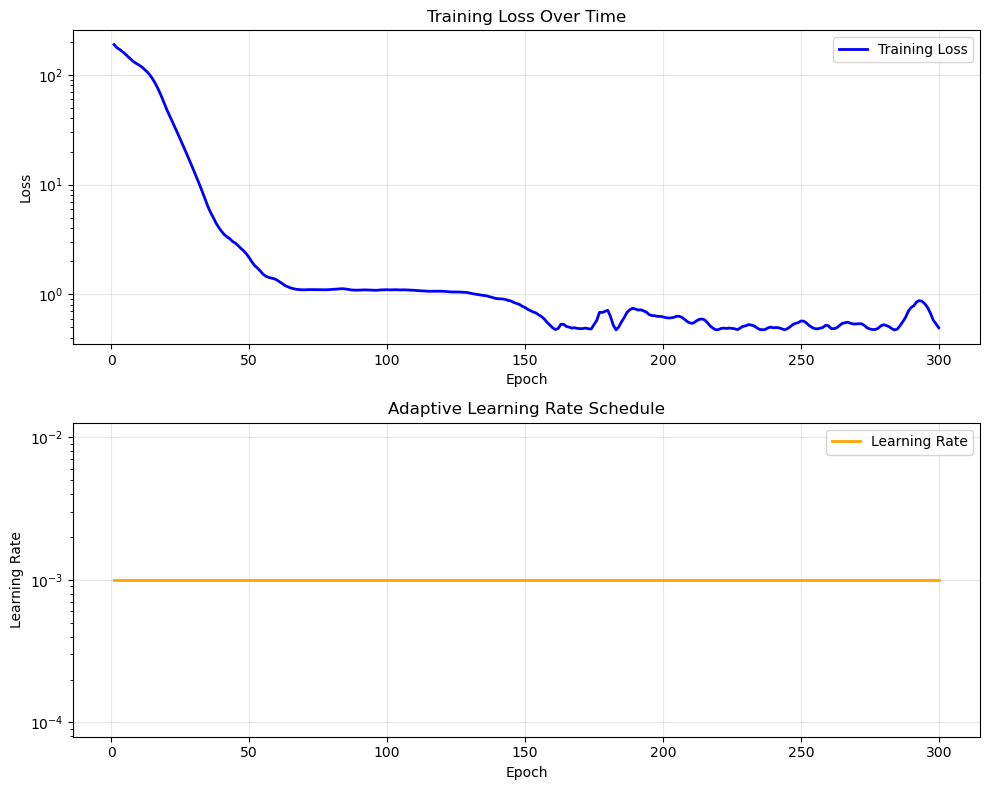

In [170]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot training loss
ax1.plot(range(1, num_epochs+1), loss_history, label='Training Loss', linewidth=2, color='blue')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss Over Time")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')  # Log scale to see details better

# Plot learning rate schedule
ax2.plot(range(1, num_epochs+1), lr_history, label='Learning Rate', color='orange', linewidth=2)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Learning Rate")
ax2.set_title("Adaptive Learning Rate Schedule")
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')  # Log scale to see LR changes

plt.tight_layout()
plt.show()


## 11. Evaluate the Final Learned Model


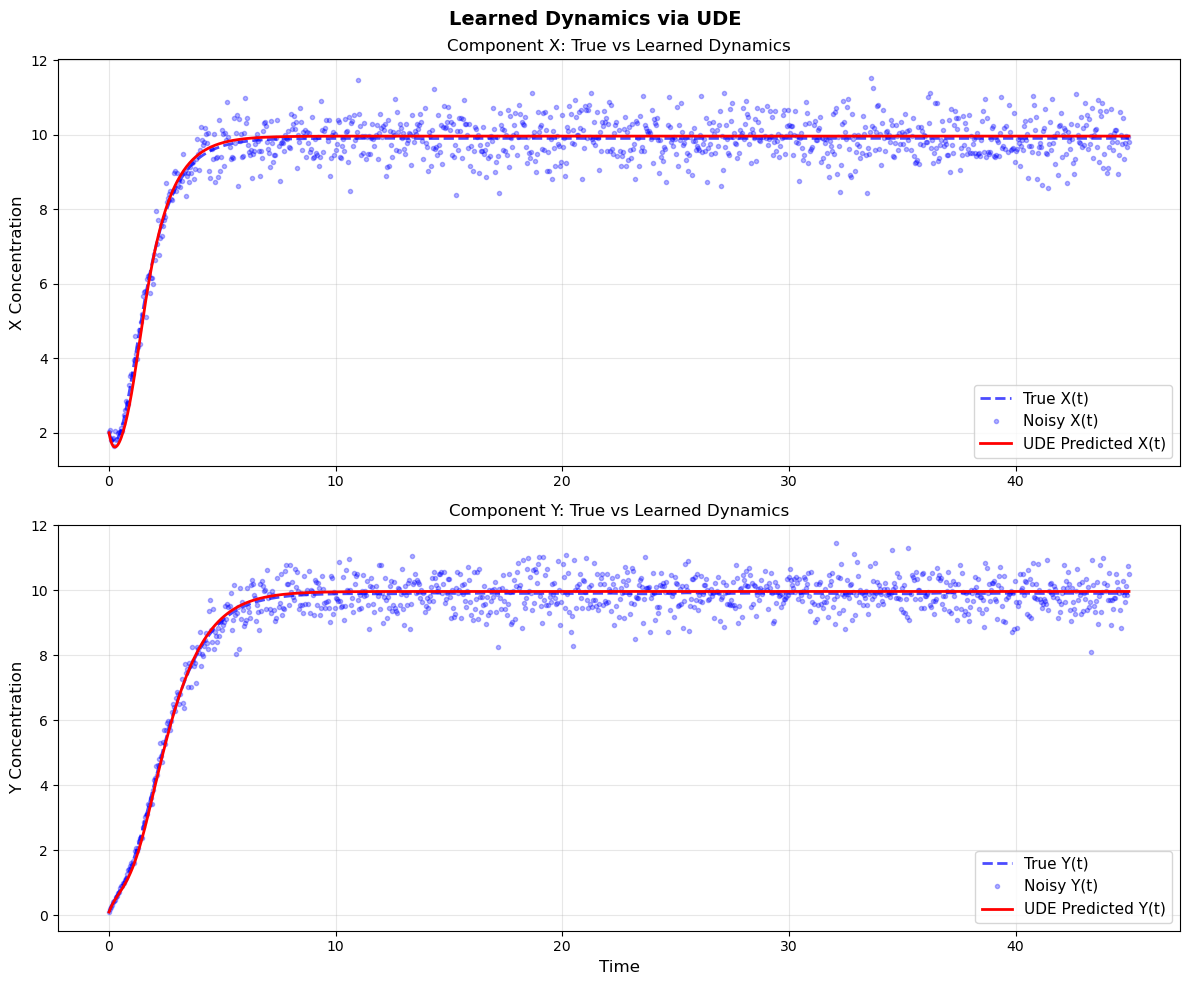


Model Performance (R² scores):
  X(t): R² = 0.9963
  Y(t): R² = 0.9986


In [171]:
# Get final predictions
with torch.no_grad():
    sol_final = forward_sim(ude, y0_torch, t_train_torch).numpy()
    
X_final = sol_final[:, 0]
Y_final = sol_final[:, 1]

# Plot results
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Component X
axes[0].plot(t_eval, X_true, 'b--', label='True X(t)', linewidth=2, alpha=0.7)
axes[0].plot(t_eval, X_noisy, 'bo', label='Noisy X(t)', markersize=3, alpha=0.3)
axes[0].plot(t_eval, X_final, 'r-', label='UDE Predicted X(t)', linewidth=2)
axes[0].set_ylabel("X Concentration", fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Component X: True vs Learned Dynamics', fontsize=12)

# Component Y
axes[1].plot(t_eval, Y_true, 'b--', label='True Y(t)', linewidth=2, alpha=0.7)
axes[1].plot(t_eval, Y_noisy, 'bo', label='Noisy Y(t)', markersize=3, alpha=0.3)
axes[1].plot(t_eval, Y_final, 'r-', label='UDE Predicted Y(t)', linewidth=2)
axes[1].set_xlabel("Time", fontsize=12)
axes[1].set_ylabel("Y Concentration", fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_title('Component Y: True vs Learned Dynamics', fontsize=12)

plt.suptitle("Learned Dynamics via UDE", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate R² scores
ss_res_X = np.sum((X_true - X_final)**2)
ss_tot_X = np.sum((X_true - np.mean(X_true))**2)
r2_X = 1 - (ss_res_X / ss_tot_X)

ss_res_Y = np.sum((Y_true - Y_final)**2)
ss_tot_Y = np.sum((Y_true - np.mean(Y_true))**2)
r2_Y = 1 - (ss_res_Y / ss_tot_Y)

print(f"\nModel Performance (R² scores):")
print(f"  X(t): R² = {r2_X:.4f}")
print(f"  Y(t): R² = {r2_Y:.4f}")


## 12. Phase Portrait Comparison


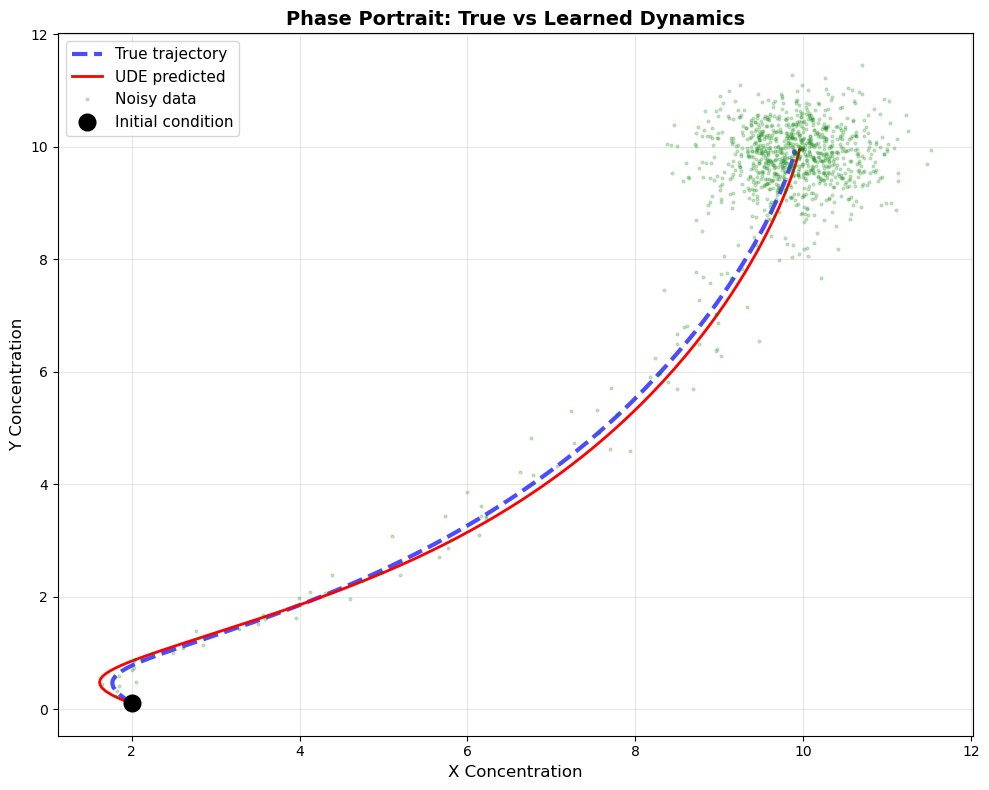

In [172]:
plt.figure(figsize=(10, 8))
plt.plot(X_true, Y_true, 'b--', label='True trajectory', linewidth=3, alpha=0.7)
plt.plot(X_final, Y_final, 'r-', label='UDE predicted', linewidth=2)
plt.plot(X_noisy, Y_noisy, 'g.', label='Noisy data', alpha=0.2, markersize=4)
plt.plot(X0, Y0, 'ko', markersize=12, label='Initial condition', zorder=5)
plt.xlabel('X Concentration', fontsize=12)
plt.ylabel('Y Concentration', fontsize=12)
plt.title('Phase Portrait: True vs Learned Dynamics', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 13. Verify the Learned Hill Function

Let's check what the neural network learned by comparing it to the true Hill function. We'll evaluate both functions over a range of $Y$ values.


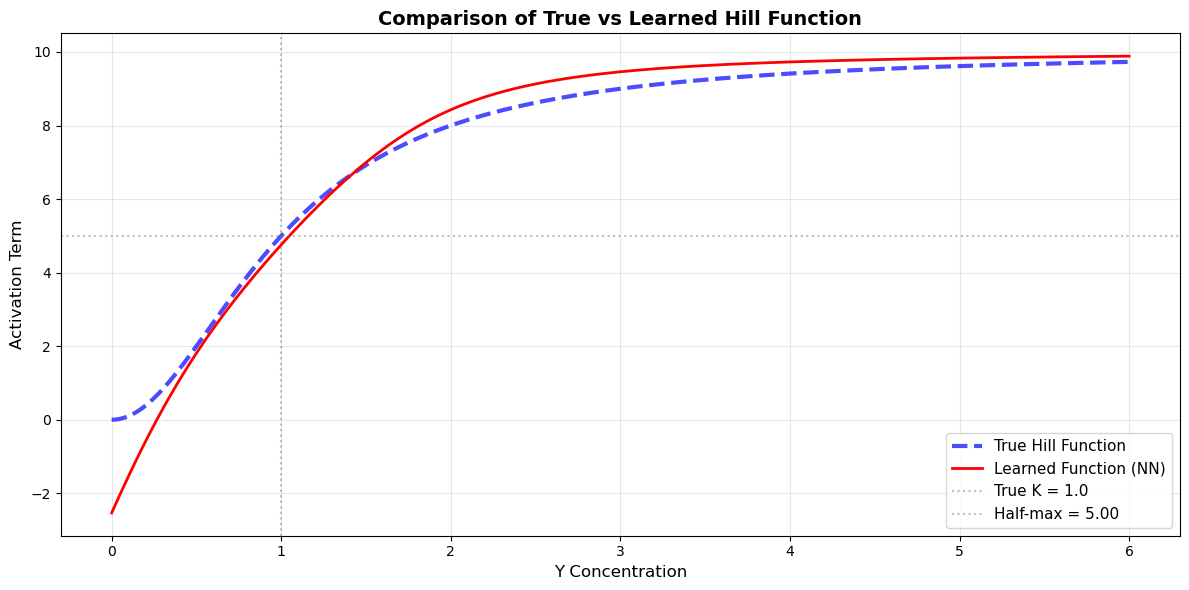


Hill Function R² score: 0.9715

True parameters:
  v = 10.00
  K = 1.00
  n = 2.00


In [173]:
# Create test points for Y
Y_test = np.linspace(0, 6, 300)
Y_test_torch = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(-1)

# Evaluate learned Hill function
with torch.no_grad():
    learned_activation = hill_nn(None, Y_test_torch).squeeze().numpy()

# True Hill function
true_activation = v_true * (Y_test**n_true) / (K_true**n_true + Y_test**n_true)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(Y_test, true_activation, 'b--', label='True Hill Function', linewidth=3, alpha=0.7)
plt.plot(Y_test, learned_activation, 'r-', label='Learned Function (NN)', linewidth=2)
plt.axvline(x=K_true, color='gray', linestyle=':', alpha=0.5, label=f'True K = {K_true:.1f}')
plt.axhline(y=v_true/2, color='gray', linestyle=':', alpha=0.5, label=f'Half-max = {v_true/2:.2f}')
plt.xlabel('Y Concentration', fontsize=12)
plt.ylabel('Activation Term', fontsize=12)
plt.title('Comparison of True vs Learned Hill Function', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate R² score for the Hill function
ss_res_hill = np.sum((true_activation - learned_activation)**2)
ss_tot_hill = np.sum((true_activation - np.mean(true_activation))**2)
r2_hill = 1 - (ss_res_hill / ss_tot_hill)

print(f"\nHill Function R² score: {r2_hill:.4f}")
print(f"\nTrue parameters:")
print(f"  v = {v_true:.2f}")
print(f"  K = {K_true:.2f}")
print(f"  n = {n_true:.2f}")


## 14. Visualize the Learned Function Along the Trajectory

Let's see how well the learned function matches the true activation term along the actual trajectory.


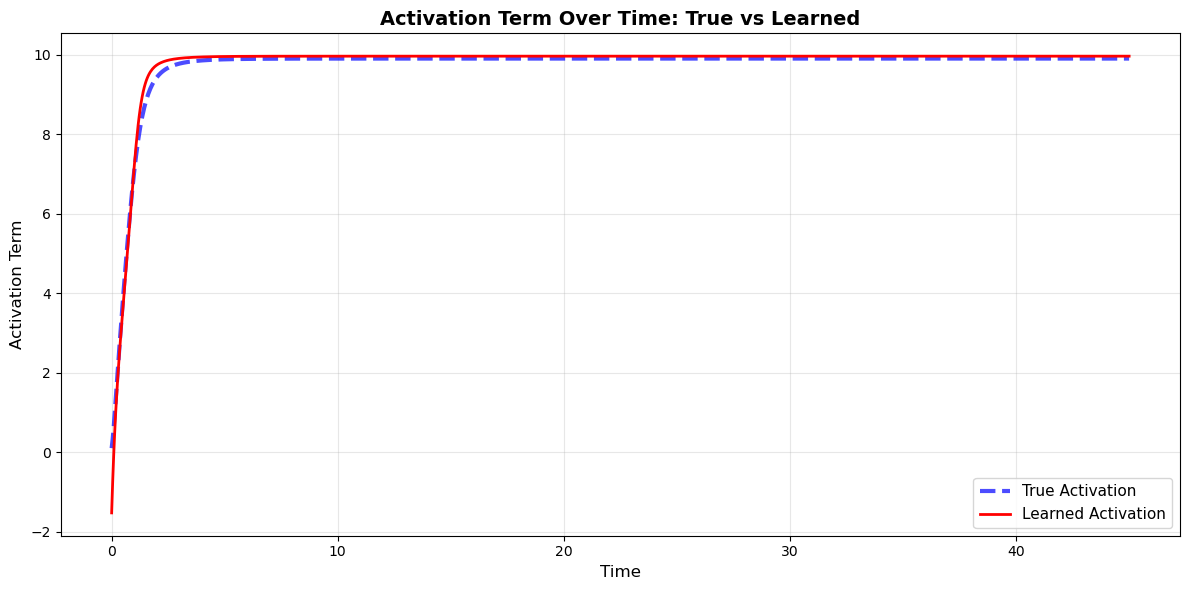


Activation term error statistics:
  Mean absolute error: 0.0784
  Max absolute error: 1.6281
  Mean relative error: 2.98%


In [174]:
# Evaluate along the true trajectory
Y_traj_torch = torch.tensor(Y_true, dtype=torch.float32).unsqueeze(-1)

with torch.no_grad():
    learned_traj = hill_nn(None, Y_traj_torch).squeeze().numpy()

true_traj = v_true * (Y_true**n_true) / (K_true**n_true + Y_true**n_true)

plt.figure(figsize=(12, 6))
plt.plot(t_eval, true_traj, 'b--', label='True Activation', linewidth=3, alpha=0.7)
plt.plot(t_eval, learned_traj, 'r-', label='Learned Activation', linewidth=2)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Activation Term', fontsize=12)
plt.title('Activation Term Over Time: True vs Learned', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Point-by-point error
abs_error = np.abs(true_traj - learned_traj)
rel_error = abs_error / (np.abs(true_traj) + 1e-8) * 100

print(f"\nActivation term error statistics:")
print(f"  Mean absolute error: {np.mean(abs_error):.4f}")
print(f"  Max absolute error: {np.max(abs_error):.4f}")
print(f"  Mean relative error: {np.mean(rel_error):.2f}%")


## 15. Summary and Discussion

### What We Did:

1. **Generated synthetic data** from a two-component self-activation loop containing a Hill function:
   - $\frac{dX}{dt} = v \cdot \frac{Y^n}{K^n + Y^n} - d \cdot X$
   - $\frac{dY}{dt} = X - d \cdot Y$

2. **Constructed a UDE** where:
   - The **Hill function** was treated as completely unknown
   - A neural network learned to approximate: $v \cdot \frac{Y^n}{K^n + Y^n}$
   - The linear production and degradation terms were kept as known physics

3. **Trained the model** using:
   - Differentiable ODE solver (`torchdiffeq`)
   - Backpropagation through the ODE solver
   - Adaptive learning rate scheduling

4. **Evaluated the results** by:
   - Comparing predicted trajectories to true dynamics
   - Directly comparing the learned Hill function to the true one
   - Analyzing phase portraits

### Key Insights:

- **Hill functions are nonlinear and sigmoidal**, making them challenging but learnable
- The neural network successfully captured:
  - The threshold behavior (around $Y = K$)
  - The cooperativity (steepness determined by $n$)
  - The maximum activation level (determined by $v$)
- UDEs allow us to **blend known biological principles** (degradation, linear production) with **data-driven discovery** (Hill activation)

### Applications in Biology:

Hill functions appear in many biological contexts:
- **Gene regulation**: Transcription factor binding and activation
- **Enzyme kinetics**: Cooperative substrate binding
- **Signal transduction**: Receptor-ligand interactions
- **Metabolism**: Allosteric regulation

When the exact form or parameters of these interactions are unknown, UDEs provide a powerful framework for:
1. Learning the functional form from data
2. Maintaining physical constraints (conservation laws, positivity)
3. Making predictions and testing interventions

### Potential Extensions:

- **Multiple Hill functions**: Learn several regulatory interactions simultaneously
- **Repression**: Learn Hill repression functions: $\frac{K^n}{K^n + Y^n}$
- **Time-varying parameters**: Model context-dependent regulation
- **Noisy dynamics**: Add stochastic components
- **Multi-component networks**: Scale to larger gene regulatory networks
- **Real data**: Apply to experimental time-series data from biological systems
- **Parameter estimation**: Extract estimated values of $v$, $K$, and $n$ from the learned function

### Challenges:

- **Identifiability**: Multiple parameter combinations can produce similar dynamics
- **Data requirements**: Need sufficient data to constrain the Hill function shape
- **Extrapolation**: Neural networks may not extrapolate well beyond the training data range
- **Physical constraints**: May need to enforce positivity or boundedness of the learned function


## Optional: Extrapolation Test

Let's test how well the learned model extrapolates to longer time horizons.


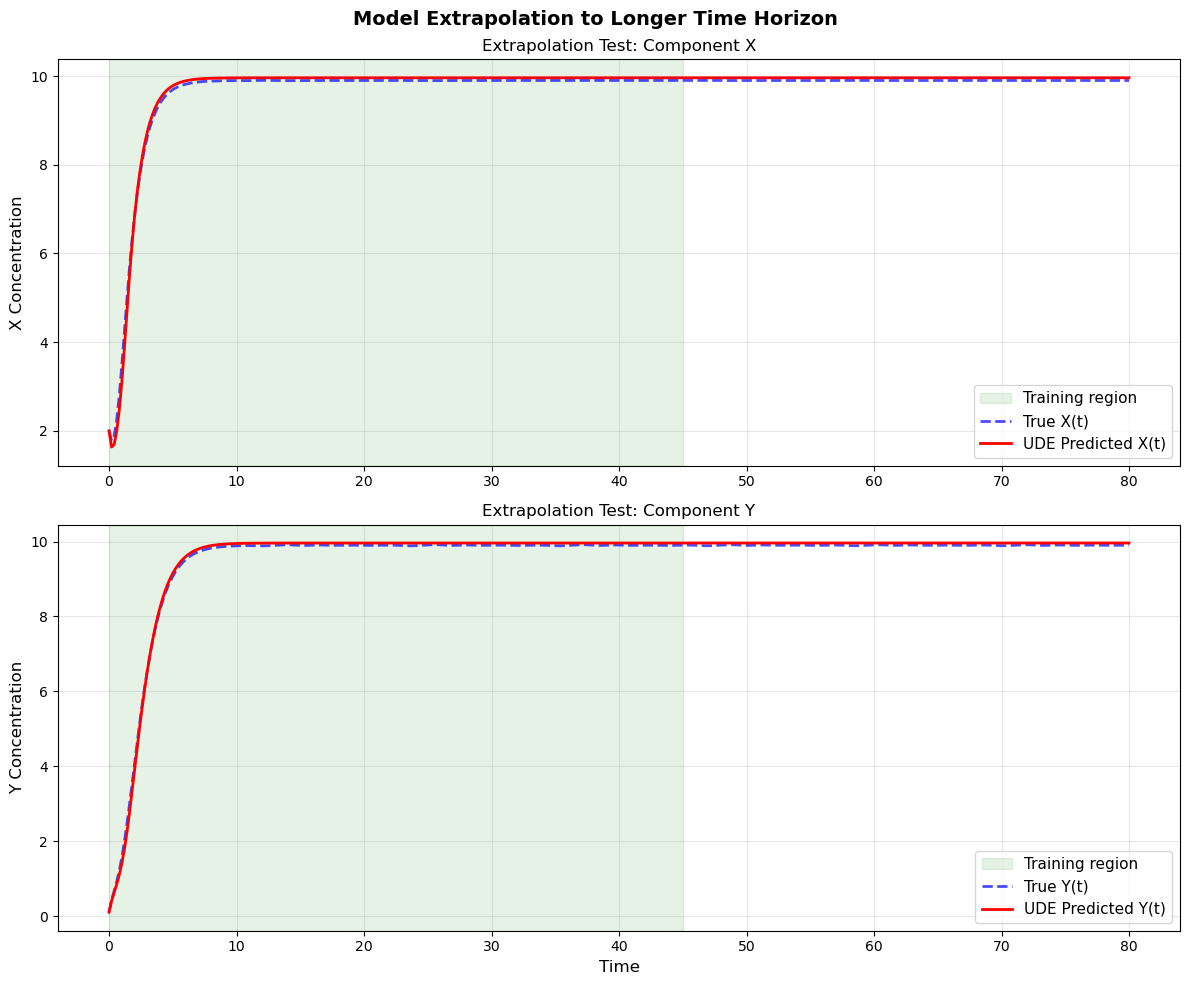


Extrapolation error (beyond t=45.0):
  X: Mean absolute error = 0.0607
  Y: Mean absolute error = 0.0593


In [175]:
# Extended time horizon
t_extended = np.linspace(0, 80, 400)
t_extended_torch = torch.tensor(t_extended, dtype=torch.float32)

# True solution for extended time
sol_extended = solve_ivp(
    hill_activation_model, 
    [0, 80], 
    y0, 
    t_eval=t_extended, 
    method='RK45'
)
X_true_ext = sol_extended.y[0, :]
Y_true_ext = sol_extended.y[1, :]

# UDE prediction for extended time
with torch.no_grad():
    sol_pred_ext = forward_sim(ude, y0_torch, t_extended_torch).numpy()
    
X_pred_ext = sol_pred_ext[:, 0]
Y_pred_ext = sol_pred_ext[:, 1]

# Plot extrapolation results
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Mark training region
axes[0].axvspan(0, t_end, alpha=0.1, color='green', label='Training region')
axes[0].plot(t_extended, X_true_ext, 'b--', label='True X(t)', linewidth=2, alpha=0.7)
axes[0].plot(t_extended, X_pred_ext, 'r-', label='UDE Predicted X(t)', linewidth=2)
axes[0].set_ylabel("X Concentration", fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Extrapolation Test: Component X', fontsize=12)

axes[1].axvspan(0, t_end, alpha=0.1, color='green', label='Training region')
axes[1].plot(t_extended, Y_true_ext, 'b--', label='True Y(t)', linewidth=2, alpha=0.7)
axes[1].plot(t_extended, Y_pred_ext, 'r-', label='UDE Predicted Y(t)', linewidth=2)
axes[1].set_xlabel("Time", fontsize=12)
axes[1].set_ylabel("Y Concentration", fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_title('Extrapolation Test: Component Y', fontsize=12)

plt.suptitle("Model Extrapolation to Longer Time Horizon", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate extrapolation error (only in the extrapolation region)
extrap_mask = t_extended > t_end
if np.any(extrap_mask):
    X_extrap_true = X_true_ext[extrap_mask]
    X_extrap_pred = X_pred_ext[extrap_mask]
    Y_extrap_true = Y_true_ext[extrap_mask]
    Y_extrap_pred = Y_pred_ext[extrap_mask]
    
    extrap_error_X = np.mean(np.abs(X_extrap_true - X_extrap_pred))
    extrap_error_Y = np.mean(np.abs(Y_extrap_true - Y_extrap_pred))
    
    print(f"\nExtrapolation error (beyond t={t_end}):")
    print(f"  X: Mean absolute error = {extrap_error_X:.4f}")
    print(f"  Y: Mean absolute error = {extrap_error_Y:.4f}")
